# ⚽ Scoutium Football Player Potential Prediction  
### 📌 *Predicting player potential classes using scout-rated attributes*

---

## 🎯 Project Objective  
The goal of this project is to predict the potential class of football players based on the attribute scores given by scouts (talent evaluators). Each player is labeled as one of the following:

- **average**  
- **highlighted**

Using machine learning models, the aim is to determine whether a player stands out or performs at an average level according to scout evaluations.

---

## 🧑‍💼 Who Is a Scout?  
A **scout** is an expert who observes football players, evaluates their current skills and potential, and provides detailed assessments. Scouts score players on multiple technical, tactical, and physical attributes.

The final goal of this project is to predict a player’s **potential label** using these attribute scores.

---

## 📂 Dataset Story  
The dataset is sourced from the Scoutium platform. It contains:

- Attribute scores given to players during matches  
- Scouts’ final potential evaluations for each player  

The data comes from **two separate CSV files**:

---

## 📁 1. `scoutium_attributes.csv`  
Contains the attribute-level evaluations given to each player.

| Variable | Description |
|----------|-------------|
| **task_response_id** | Set of evaluations by a scout for a match |
| **match_id** | Match ID |
| **evaluator_id** | Scout ID |
| **player_id** | Player ID |
| **position_id** | Player's position in the match |
| **analysis_id** | Set of attribute ratings given to a player |
| **attribute_id** | ID of the evaluated attribute |
| **attribute_value** | Score given to that attribute |

### Position ID Reference
1: Goalkeeper  
2: Centre-back  
3: Right-back  
4: Left-back  
5: Defensive midfielder  
6: Central midfielder  
7: Right winger  
8: Left winger  
9: Attacking midfielder  
10: Striker


---

## 📁 2. `scoutium_potential_labels.csv`  
Contains the **target variable**: the final potential decision made by the scout.

| Variable | Description |
|----------|-------------|
| **task_response_id** | Evaluation set ID |
| **match_id** | Match ID |
| **evaluator_id** | Scout ID |
| **player_id** | Player ID |
| **potential_label** | Final potential decision (average / highlighted) |

---

## 📊 Project Workflow  
This notebook includes:

- Merging the attribute and label datasets  
- Filtering positions and removing unwanted labels  
- Creating a pivot table to generate a player–attribute matrix  
- Label encoding and feature standardization  
- Building models using Random Forest, GradientBoosting, CatBoost, and LightGBM  
- Hyperparameter optimization with GridSearchCV  
- Visualizing feature importance  

---

## 🎉 Expected Outcome  
Using the attribute evaluations, the goal is to predict whether a player is:

➡️ **average** or  
➡️ **highlighted**

based on scout assessments.

---



# 🔧 1. Import Required Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)
import warnings
warnings.simplefilter(action="ignore")

# 📥 2. Loading the Dataset

In [2]:
attributes = pd.read_csv("/kaggle/input/scoutium-th/scoutium_attributes.csv", sep=";")
potential = pd.read_csv("/kaggle/input/scoutium-th/scoutium_potential_labels.csv" , sep=";")

In [3]:
print("Attributes")
print(attributes.head())
print("Potential")
print(potential.head())

Attributes
   task_response_id  match_id  evaluator_id  player_id  position_id  analysis_id  attribute_id  attribute_value
0              4915     62935        177676    1361061            2     12818495          4322           56.000
1              4915     62935        177676    1361061            2     12818495          4323           56.000
2              4915     62935        177676    1361061            2     12818495          4324           67.000
3              4915     62935        177676    1361061            2     12818495          4325           56.000
4              4915     62935        177676    1361061            2     12818495          4326           45.000
Potential
   task_response_id  match_id  evaluator_id  player_id potential_label
0              4915     62935        177676    1361061         average
1              4915     62935        177676    1361626     highlighted
2              4915     62935        177676    1361858         average
3              4915    

# 🔧 3. Data Merging, Filtering, and Label Cleaning

In [4]:
df = pd.merge( attributes, potential , how="right" , on=["task_response_id" , "match_id" , "evaluator_id" , "player_id"])
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


In [5]:
df = df.loc[~(df["position_id"] == 1)]
df["position_id"].value_counts()

position_id
2     1972
6     1428
10    1088
8     1020
7      986
3      986
4      884
9      850
5      816
Name: count, dtype: int64

In [6]:
df.drop(df.loc[df["potential_label"]== "below_average"].index, inplace=True)
df["potential_label"].value_counts()


potential_label
average        7922
highlighted    1972
Name: count, dtype: int64

# 📊 4. Creating Player–Attribute Pivot Table

In [7]:
df_pivot = df.pivot_table(index=["player_id" , "position_id" , "potential_label"] , columns=["attribute_id"] , values="attribute_value")

In [8]:
df_pivot

attribute_id                            4322   4323   4324   4325   4326   4327   4328   4329   4330   4332   4333   4335   4338   4339   4340   4341   4342   4343   4344   4345   4348   4349   4350   4351   4352   4353   4354   4355   4356   4357   4407   4408   4423   4426
player_id position_id potential_label                                                                                                                                                                                                                                              
1355710   7           average         50.500 50.500 34.000 50.500 45.000 45.000 45.000 45.000 50.500 56.000 39.500 34.000 39.500 39.500 45.000 45.000 50.500 28.500 23.000 39.500 28.500 28.500 45.000 50.500 56.000 34.000 39.500 50.500 34.000 34.000 56.000 34.000 34.000 56.000
1356362   9           average         67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 56.000 67.000 67.000 56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 67.000 67.000 56.000 78.000
1356375   3           average         67.000 67.000 67.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000 56.000 67.000 67.000 67.000 67.000 67.000 56.000 56.000 67.000 67.000 56.000 56.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 67.000 67.000 56.000 78.000
          4           average         67.000 78.000 67.000 67.000 67.000 78.000 78.000 78.000 56.000 67.000 67.000 67.000 78.000 78.000 56.000 67.000 67.000 45.000 45.000 56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 56.000 67.000 56.000 67.000 45.000 56.000
1356411   9           average         67.000 67.000 78.000 78.000 67.000 67.000 67.000 67.000 89.000 78.000 67.000 67.000 67.000 56.000 56.000 67.000 78.000 56.000 56.000 67.000 56.000 67.000 56.000 67.000 67.000 56.000 67.000 67.000 56.000 67.000 89.000 56.000 67.000 78.000
...                                      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
1907347   5           average         67.000 78.000 78.000 56.000 78.000 67.000 78.000 67.000 56.000 78.000 78.000 56.000 67.000 67.000 78.000 56.000 67.000 56.000 56.000 67.000 78.000 89.000 67.000 78.000 67.000 67.000 67.000 67.000 56.000 67.000 78.000 78.000 78.000 56.000
          6           average         67.000 67.000 67.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000 56.000 67.000 67.000 67.000 67.000 78.000 67.000 56.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 67.000 67.000 67.000 78.000
1909532   10          average         56.000 45.000 45.000 45.000 56.000 56.000 56.000 56.000 23.000 23.000 34.000 45.000 56.000 34.000 23.000 45.000 45.000 23.000 23.000 34.000 23.000 23.000 34.000 23.000 45.000 45.000 56.000 34.000 34.000 56.000 34.000 34.000 34.000 23.000
1909724   2           highlighted     78.000 78.000 78.000 78.000 78.000 78.000 78.000 78.000 67.000 67.000 78.000 78.000 78.000 67.000 78.000 67.000 78.000 56.000 56.000 78.000 78.000 67.000 78.000 78.000 78.000 78.000 78.000 67.000 67.000 67.000 78.000 78.000 67.000 78.000
1909728   7           highlighted     78.000 67.000 67.000 78.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000 67.000 78.000 67.000 67.000 78.000 78.000 67.000 56.000 78.000 67.000 56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000

[271 rows x 34 columns]

In [9]:
df_pivot = df_pivot.reset_index()
df_pivot.columns = df_pivot.columns.astype(str)
df_pivot

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,1907347,5,average,67.000,78.000,78.000,56.000,78.000,67.000,78.000,67.000,56.000,78.000,78.000,56.000,67.000,67.000,78.000,56.000,67.000,56.000,56.000,67.000,78.000,89.000,67.000,78.000,67.000,67.000,67.000,67.000,56.000,67.000,78.000,78.000,78.000,56.000
267,1907347,6,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,56.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000
268,1909532,10,average,56.000,45.000,45.000,45.000,56.000,56.000,56.000,56.000,23.000,23.000,34.000,45.000,56.000,34.000,23.000,45.000,45.000,23.000,23.000,34.000,23.000,23.000,34.000,23.000,45.000,45.000,56.000,34.000,34.000,56.000,34.000,34.000,34.000,23.000
269,1909724,2,highlighted,78.000,78.000,78.000,78.000,78.000,78.000,78.000,78.000,67.000,67.000,78.000,78.000,78.000,67.000,78.000,67.000,78.000,56.000,56.000,78.000,78.000,67.000,78.000,78.000,78.000,78.000,78.000,67.000,67.000,67.000,78.000,78.000,67.000,78.000


# 🔢 5. Encoding Potential Labels (Label Encoding)

In [10]:
df_pivot["potential_label"] = LabelEncoder().fit_transform(df_pivot["potential_label"])

In [11]:
df_pivot.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,0,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,0,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


# 🔢 6. Classifying Variables: Numerical vs Categorical

In [12]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    #categorical
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and dataframe[col].nunique() < cat_th]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == "O" and dataframe[col].nunique() > car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    #numeric
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat
    

cat_cols , num_cols , cat_but_car , num_but_cat = grab_col_names(df_pivot)

Observations: 271
Variables: 37
cat_cols: 7
num_cols: 30
cat_but_car: 0
num_but_cat: 7


In [13]:
num_cols

['player_id',
 '4322',
 '4323',
 '4325',
 '4326',
 '4327',
 '4329',
 '4330',
 '4332',
 '4333',
 '4335',
 '4338',
 '4339',
 '4340',
 '4341',
 '4342',
 '4343',
 '4344',
 '4345',
 '4348',
 '4349',
 '4350',
 '4351',
 '4353',
 '4354',
 '4355',
 '4356',
 '4407',
 '4408',
 '4426']

# ⚖️ 7. Scaling Numeric Features (Standardization)

In [14]:
num_cols.remove("player_id")
df_pivot[num_cols] = StandardScaler().fit_transform(df_pivot[num_cols])
df_pivot.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.543,-0.559,34.000,-0.438,-0.767,-0.795,45.000,-0.792,-0.446,-0.123,-1.224,-1.036,-1.126,-1.009,-0.542,-0.690,-0.535,-1.067,-1.206,-1.005,-1.314,-1.042,-0.693,-0.436,56.000,-1.282,-1.132,-0.495,-1.235,34.000,-0.143,-1.487,34.000,-0.253
1,1356362,9,0,0.595,0.561,67.000,0.683,0.723,0.723,67.000,0.404,0.728,0.691,0.459,0.996,0.632,0.840,0.912,0.799,0.588,1.230,0.750,0.742,0.879,0.670,0.848,0.717,67.000,0.814,1.053,0.632,0.915,67.000,0.530,0.669,56.000,1.042
2,1356375,3,0,0.595,0.561,67.000,0.683,0.723,0.723,67.000,1.002,0.728,0.691,1.132,0.319,0.632,0.840,0.912,0.799,0.588,0.574,0.750,0.742,0.879,0.670,0.077,0.717,67.000,0.814,1.053,0.632,0.915,67.000,0.530,0.669,56.000,1.042
3,1356375,4,0,0.595,1.308,67.000,0.683,0.723,1.482,78.000,1.002,-0.055,0.691,0.459,0.996,1.335,1.580,0.185,0.799,0.588,-0.083,0.098,0.043,0.879,1.355,0.848,0.717,78.000,0.814,0.428,0.632,0.198,67.000,-0.143,0.669,45.000,-0.253
4,1356411,9,0,0.595,0.561,78.000,1.430,0.723,0.723,67.000,0.404,2.294,1.505,0.459,0.996,0.632,0.101,0.185,0.799,1.337,0.574,0.750,0.742,0.252,1.355,0.077,0.717,67.000,0.115,0.428,0.632,0.198,67.000,1.874,-0.050,67.000,1.042


# 🤖 8. Modeling

In [15]:
X = df_pivot.drop(["potential_label", "player_id"], axis=1)
y = df_pivot["potential_label"]

In [16]:
models = [('LR', LogisticRegression()),
          ("KNN", KNeighborsClassifier()),
          ("CART", DecisionTreeClassifier()),
          ("RF", RandomForestClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
          ("LightGBM", LGBMClassifier(verbosity=-1)),
          ('CatBoost', CatBoostClassifier(verbose=False))]

last_models_metrics = []

for name , model in models:
    cv_results = cross_validate(model , X , y , cv=5 , scoring=["f1" ,"roc_auc", "recall"  ,"accuracy" , "precision"] , n_jobs=1)

    accuracy = round(cv_results['test_accuracy'].mean(), 4)
    auc = round(cv_results['test_roc_auc'].mean(), 4)
    recall = round(cv_results['test_recall'].mean(), 4)
    precision = round(cv_results['test_precision'].mean(), 4)
    f1 = round(cv_results['test_f1'].mean(), 4)

    last_models_metrics.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Recall": recall,
        "Precision": precision,
        "F1": f1
    })

    print(f"########## {name} ##########")
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1: {f1}")


########## LR ##########
Accuracy: 0.849
AUC: 0.8056
Recall: 0.4667
Precision: 0.715
F1: 0.5542
########## KNN ##########
Accuracy: 0.8007
AUC: 0.776
Recall: 0.1955
Precision: 0.495
F1: 0.2712
########## CART ##########
Accuracy: 0.79
AUC: 0.7201
Recall: 0.603
Precision: 0.544
F1: 0.5502
########## RF ##########
Accuracy: 0.8818
AUC: 0.9071
Recall: 0.4788
Precision: 0.9111
F1: 0.6193
########## GBM ##########
Accuracy: 0.8599
AUC: 0.8772
Recall: 0.55
Precision: 0.7458
F1: 0.6165
########## XGBoost ##########
Accuracy: 0.8526
AUC: 0.8716
Recall: 0.5515
Precision: 0.7217
F1: 0.6084
########## LightGBM ##########
Accuracy: 0.8672
AUC: 0.8804
Recall: 0.55
Precision: 0.7781
F1: 0.6256
########## CatBoost ##########
Accuracy: 0.8709
AUC: 0.8915
Recall: 0.4606
Precision: 0.8933
F1: 0.5852


# 🚀 9. Hyperparameter Optimization for Multiple Classifiers

In [17]:
rf_params = {
    "max_depth": [8, 15, None],
    "max_features": [5, 7],
    "min_samples_split": [15, 20],
    "n_estimators": [200, 300]
}

gbm_params = {
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 8, 10],
    "n_estimators": [250, 500],
    "subsample": [1, 0.5, 0.7]
}

lightgbm_params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [300, 500, 700],
    "num_leaves": [15, 31, 63],
    "max_depth": [-1, 5, 10],
    "min_child_samples": [5, 10, 20],
    "subsample": [0.7, 0.9, 1.0],         
  
}

catboost_params = {
    "iterations": [200, 500],
    "learning_rate": [0.01, 0.1],
    "depth": [3, 6]
}

classifiers = [
    ('GBM', GradientBoostingClassifier(), gbm_params),
    ('RF', RandomForestClassifier(), rf_params),
    ('CatBoost', CatBoostClassifier(verbose=False), catboost_params),
    ('LightGBM', LGBMClassifier(verbosity=-1), lightgbm_params)
]


def hyperparameter_optimization(
        X, y,
        cv=5,
        scoring=["accuracy", "f1", "roc_auc", "precision", "recall"]):

    print("Hyperparameter Optimization")
    best_models = {}

    for name, classifier, params in classifiers:
        print(f"########## {name} #########")

        # İlk sonuçlar (varsayılan parametrelerle)
        cv_results = cross_validate(
            classifier, X, y, cv=cv, scoring=scoring, n_jobs=-1
        )

        print(f"Accuracy (Before): {round(cv_results['test_accuracy'].mean(), 4)}")
        print(f"F1 (Before): {round(cv_results['test_f1'].mean(), 4)}")
        print(f"ROC AUC (Before): {round(cv_results['test_roc_auc'].mean(), 4)}")

        # Grid Search ile en iyi parametreleri bul
        gs_best = GridSearchCV(
            classifier,
            params,
            cv=cv,
            n_jobs=-1,
            verbose=0
        ).fit(X, y)

        # En iyi parametrelerle final model
        final_model = classifier.set_params(**gs_best.best_params_)

        # Final model performansı (cross-validate)
        cv_results = cross_validate(
            final_model, X, y, cv=cv, scoring=scoring, n_jobs=-1
        )

        print(f"Accuracy (After) : {round(cv_results['test_accuracy'].mean(), 4)}")
        print(f"F1 (After) : {round(cv_results['test_f1'].mean(), 4)}")
        print(f"ROC AUC (After) : {round(cv_results['test_roc_auc'].mean(), 4)}")
        print(f"Precision (After) : {round(cv_results['test_precision'].mean(), 4)}")
        print(f"Recall (After) : {round(cv_results['test_recall'].mean(), 4)}")

        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

        best_models[name] = final_model

    return best_models


best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization
########## GBM #########
Accuracy (Before): 0.8598
F1 (Before): 0.6033
ROC AUC (Before): 0.8782
Accuracy (After) : 0.8747
F1 (After) : 0.6493
ROC AUC (After) : 0.8898
Precision (After) : 0.7998
Recall (After) : 0.5682
GBM best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.5}

########## RF #########
Accuracy (Before): 0.8708
F1 (Before): 0.6019
ROC AUC (Before): 0.9002
Accuracy (After) : 0.8744
F1 (After) : 0.5784
ROC AUC (After) : 0.9006
Precision (After) : 0.897
Recall (After) : 0.4591
RF best params: {'max_depth': 15, 'max_features': 5, 'min_samples_split': 20, 'n_estimators': 300}

########## CatBoost #########
Accuracy (Before): 0.8709
F1 (Before): 0.5852
ROC AUC (Before): 0.8915
Accuracy (After) : 0.882
F1 (After) : 0.6634
ROC AUC (After) : 0.8811
Precision (After) : 0.8148
Recall (After) : 0.5848
CatBoost best params: {'depth': 3, 'iterations': 500, 'learning_rate': 0.1}

########## LightGBM #########
Accuracy (Bef

In [18]:
final_model = best_models["LightGBM"]
final_model.set_params(random_state=17)
final_model.fit(X, y)

LGBMClassifier(learning_rate=0.01, n_estimators=500, num_leaves=15,
               random_state=17, subsample=0.7, verbosity=-1)

In [19]:
cv_results = cross_validate(final_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())


0.8893602693602694
0.6781589267285861
0.8763213530655392


# 📈 10. Feature Importance Visualization

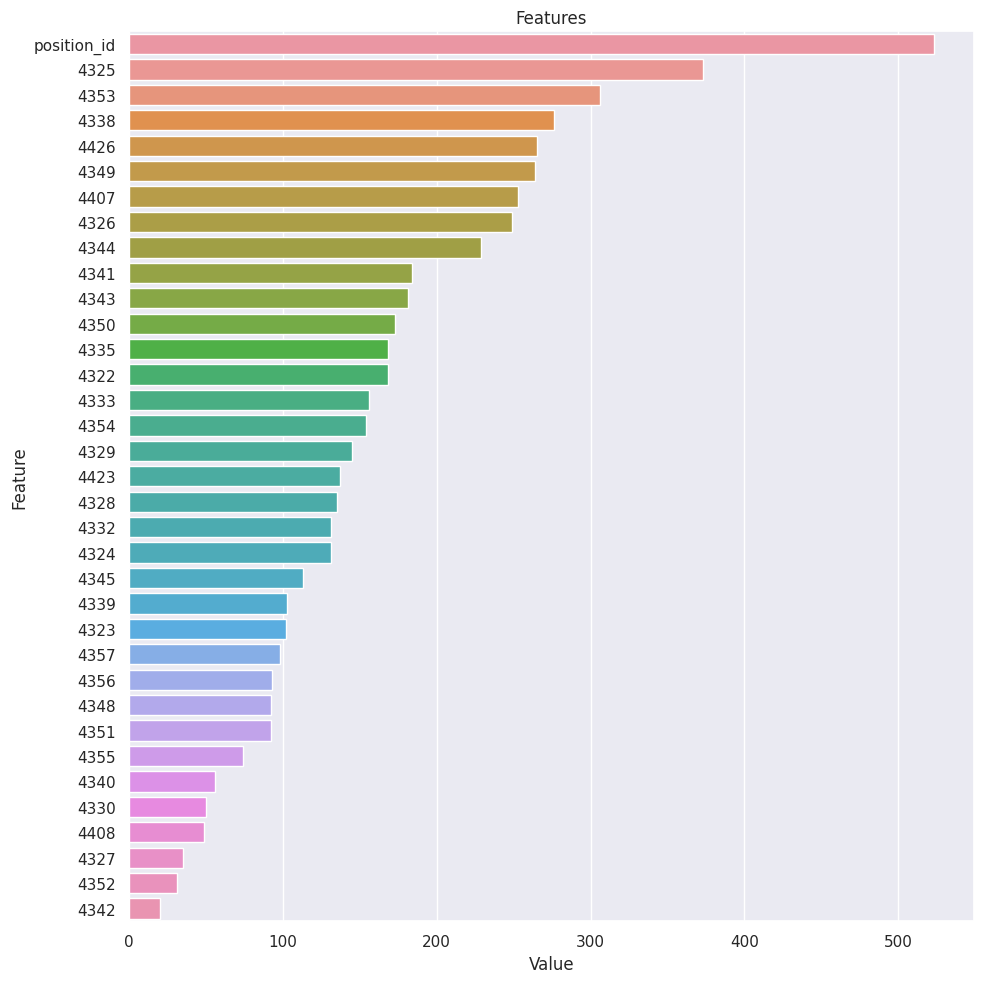

In [20]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')




plot_importance(final_model , X)